In [1]:
# Step 0 — Imports
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fix random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


2025-11-16 23:14:04.838995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763334845.088872      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763334845.161394      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Step 1 — Paths
DATASET_PATHS = [
    '/kaggle/input/fruit-recognition',
    '/kaggle/input/fruits-fresh-and-rotten-for-classification',
    
]

MERGED_ROOT = '/kaggle/working/merged_fruits_dataset'
IMG_SIZE = (128, 128)
os.makedirs(MERGED_ROOT, exist_ok=True)


In [3]:
# Step 2 — Merge datasets (recursive)
def copy_images(src_folder, dest_root):
    for root, dirs, files in os.walk(src_folder):
        # class name = top-level folder under src_folder
        # We get relative path to src_folder
        rel_path = os.path.relpath(root, src_folder)
        if rel_path == '.':
            continue  # skip root itself
        class_name = rel_path.replace(" ", "_")  # remove spaces
        dest_dir = os.path.join(dest_root, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                src_path = os.path.join(root, f)
                dest_path = os.path.join(dest_dir, f)
                if os.path.exists(dest_path):
                    base, ext = os.path.splitext(f)
                    dest_path = os.path.join(dest_dir, base + f"_{random.randint(0,9999)}" + ext)
                shutil.copy(src_path, dest_path)

# Merge all datasets
for dataset in DATASET_PATHS:
    copy_images(dataset, MERGED_ROOT)

# Check classes and number of images
print("Classes and counts after merging:")
for cls in os.listdir(MERGED_ROOT):
    print(cls, len(os.listdir(os.path.join(MERGED_ROOT, cls))))


Classes and counts after merging:
Orange 3012
Persimmon 2072
Peach 2629
Pear 3012
Guava 4
Pitaya 2501
Apple 7
Plum 2298
Banana 3027
Pomegranate 2167
dataset 3
muskmelon 2078
Carambola 2080
Tomatoes 2171
Kiwi 4
Mango 4154


In [4]:
!pip install scikit-image


In [5]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm


In [7]:
DATASET_DIR = "/kaggle/working/merged_fruits_dataset"  # put your merged dataset path here


In [8]:
images = []
labels = []

for cls in sorted(os.listdir(DATASET_DIR)):
    cls_path = os.path.join(DATASET_DIR, cls)

    if not os.path.isdir(cls_path):
        continue

    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (128, 128))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        images.append(gray)
        labels.append(cls)


In [9]:
images = np.array(images)
labels = np.array(labels)

print("Total images:", len(images))
print("Classes:", np.unique(labels))

Total images: 31201
Classes: ['Banana' 'Carambola' 'Mango' 'Orange' 'Peach' 'Pear' 'Persimmon' 'Pitaya'
 'Plum' 'Pomegranate' 'Tomatoes' 'muskmelon']


In [10]:
#Step 3 — Fast HOG + LBP Feature Extraction
hog_features = []
lbp_features = []

for img in tqdm(images, desc="Extracting features"):
    
    # ---- HOG ----
    h = hog(img,
            orientations=8,
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            visualize=False)
    hog_features.append(h)

    # ---- LBP ----
    lbp = local_binary_pattern(img, P=8, R=1)
    hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    lbp_features.append(hist)


Extracting features: 100%|██████████| 31201/31201 [03:17<00:00, 157.79it/s]


In [11]:
#Combine HOG + LBP:
X = np.hstack([hog_features, lbp_features])
y = labels

In [12]:
#Step 4 — Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [14]:
#Define evaluation function
def evaluate_model(model, name):
    print(f"\n==================== {name} ====================\n")
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    print("Accuracy:", acc)

    print("\nClassification Report:\n")
    print(classification_report(y_test, preds))

    print("\nConfusion Matrix:\n")
    cm = confusion_matrix(y_test, preds)
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc



==================== Random Forest ====================

Accuracy: 0.8360839609037013

Classification Report:

              precision    recall  f1-score   support

      Banana       0.74      0.86      0.80       606
   Carambola       0.94      0.77      0.85       416
       Mango       0.63      0.87      0.73       831
      Orange       0.71      0.81      0.76       603
       Peach       0.98      0.86      0.92       526
        Pear       0.86      0.77      0.81       602
   Persimmon       0.92      0.80      0.86       414
      Pitaya       0.95      0.84      0.89       500
        Plum       0.99      0.99      0.99       460
 Pomegranate       0.96      0.80      0.87       433
    Tomatoes       0.88      0.86      0.87       434
   muskmelon       0.99      0.77      0.86       416

    accuracy                           0.84      6241
   macro avg       0.88      0.83      0.85      6241
weighted avg       0.86      0.84      0.84      6241


Confusion Matrix:

[

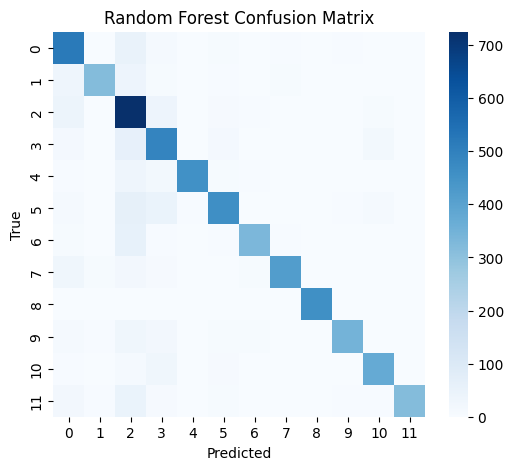

In [16]:
rf_model = RandomForestClassifier(n_estimators=120)
rf_acc = evaluate_model(rf_model, "Random Forest")



==================== Logistic Regression ====================



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7380227527639801

Classification Report:

              precision    recall  f1-score   support

      Banana       0.76      0.75      0.75       606
   Carambola       0.71      0.73      0.72       416
       Mango       0.66      0.71      0.68       831
      Orange       0.64      0.67      0.65       603
       Peach       0.79      0.79      0.79       526
        Pear       0.70      0.64      0.67       602
   Persimmon       0.79      0.74      0.76       414
      Pitaya       0.75      0.75      0.75       500
        Plum       0.88      0.92      0.90       460
 Pomegranate       0.74      0.73      0.73       433
    Tomatoes       0.82      0.84      0.83       434
   muskmelon       0.71      0.67      0.69       416

    accuracy                           0.74      6241
   macro avg       0.75      0.74      0.74      6241
weighted avg       0.74      0.74      0.74      6241


Confusion Matrix:

[[452  12  36  13   5  31   6  20   2  12   5  12]
 [ 21 30

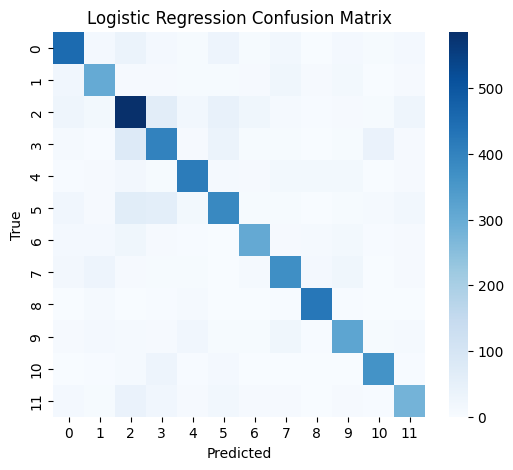

In [18]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_acc = evaluate_model(lr_model, "Logistic Regression")



==================== KNN ====================

Accuracy: 0.7500400576830636

Classification Report:

              precision    recall  f1-score   support

      Banana       0.67      0.68      0.68       606
   Carambola       0.68      0.64      0.66       416
       Mango       0.70      0.71      0.70       831
      Orange       0.66      0.69      0.67       603
       Peach       0.81      0.81      0.81       526
        Pear       0.76      0.75      0.75       602
   Persimmon       0.78      0.76      0.77       414
      Pitaya       0.75      0.74      0.75       500
        Plum       0.89      0.97      0.93       460
 Pomegranate       0.80      0.77      0.79       433
    Tomatoes       0.82      0.77      0.79       434
   muskmelon       0.80      0.74      0.77       416

    accuracy                           0.75      6241
   macro avg       0.76      0.75      0.76      6241
weighted avg       0.75      0.75      0.75      6241


Confusion Matrix:

[[415  16  

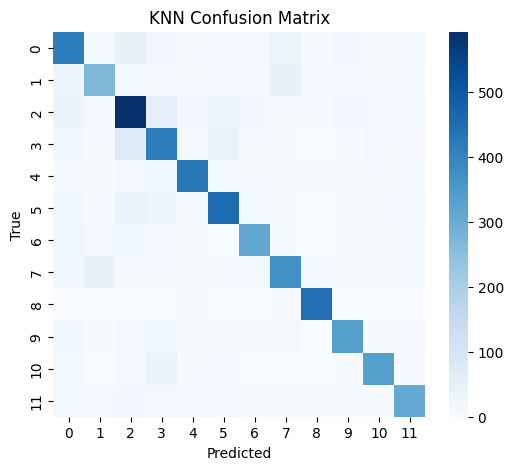

In [19]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_acc = evaluate_model(knn_model, "KNN")


==================== Decision Tree ====================

Accuracy: 0.6141643967312931

Classification Report:

              precision    recall  f1-score   support

      Banana       0.54      0.49      0.51       606
   Carambola       0.55      0.54      0.55       416
       Mango       0.58      0.60      0.59       831
      Orange       0.50      0.50      0.50       603
       Peach       0.70      0.69      0.69       526
        Pear       0.60      0.59      0.59       602
   Persimmon       0.69      0.68      0.69       414
      Pitaya       0.61      0.61      0.61       500
        Plum       0.84      0.85      0.85       460
 Pomegranate       0.59      0.61      0.60       433
    Tomatoes       0.64      0.67      0.65       434
   muskmelon       0.61      0.62      0.61       416

    accuracy                           0.61      6241
   macro avg       0.62      0.62      0.62      6241
weighted avg       0.61      0.61      0.61      6241


Confusion Matrix:

[

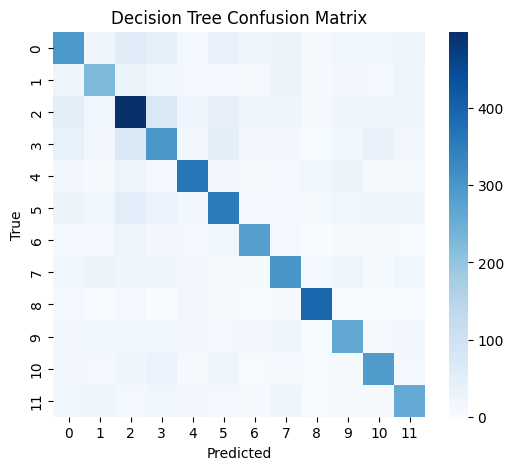

In [21]:

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_acc = evaluate_model(dt_model, "Decision Tree")

In [23]:
results = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression", "KNN", "Decision Tree"],
    "Accuracy": [ rf_acc,lr_acc,knn_acc,dt_acc]
})
print("\n=== Final Accuracy Comparison ===\n")
print(results)


=== Final Accuracy Comparison ===

                 Model  Accuracy
0        Random Forest  0.836084
1  Logistic Regression  0.738023
2                  KNN  0.750040
3        Decision Tree  0.614164
